In [55]:
from __future__ import annotations
from dataclasses import dataclass
import json
from typing import List, Tuple, Dict, Any, Iterable
import hashlib
import tiktoken
from langchain_text_splitters import RecursiveCharacterTextSplitter
from FlagEmbedding import BGEM3FlagModel, FlagReranker
import numpy as np
import math
from typing import Sequence, Iterable
import os
from dotenv import load_dotenv
import google.genai as genai
from pathlib import Path

# Visual & Data libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import ipywidgets as widgets
from IPython.display import display, clear_output

load_dotenv()
# Configuration
pd.set_option('display.max_colwidth', 100)
sns.set_theme(style="whitegrid")

# Dataclasses

In [44]:
@dataclass
class Chunk:
    id: str
    text: str
    metadata: Dict[str, Any]


@dataclass
class CorpusRow:
    id: str
    vector: np.ndarray
    metadata: Dict[str, Any]
    text: str
    

# Utilities

In [53]:
def _stable_chunk_id(source_id: str, chunk_index: int, text: str) -> str:
    h = hashlib.sha256(text.encode("utf-8")).hexdigest()[:16]
    return f"{source_id}:{chunk_index}:{h}"

def load_documents() -> List[Dict[str, Any]]:
    return [
        {
            "source_id": "policy_returns_tr",
            "title": "İade Politikası",
            "url": "https://example.com/iade",
            "text": (
                "İade politikamız aşağıdaki gibidir.\n\n"
                "1) Teslimat tarihinden itibaren 14 gün içinde iade talebi oluşturabilirsiniz. "
                "Ürün kullanılmamış olmalıdır.\n\n"
                "2) Kargo takip numarası sipariş sayfasında yer alır. "
                "İade kargo bedeli kampanya dönemlerinde ücretsiz olabilir.\n\n"
                "3) İade onayı sonrasında ücret iadesi 3-10 iş günü içinde gerçekleştirilir.\n"
            ),
        },
        {
            "source_id": "policy_privacy_tr",
            "title": "Gizlilik Politikası",
            "url": "https://example.com/gizlilik",
            "text": (
                "Gizlilik politikamız aşağıdaki gibidir.\n\n"
                "1) Kişisel verileriniz, hizmet sunumu ve müşteri desteği amaçlarıyla işlenir.\n\n"
                "2) Verileriniz, yasal yükümlülükler veya açık rızanız olmaksızın üçüncü taraflarla paylaşılmaz.\n\n"
                "3) Çerezler (cookies), deneyimi iyileştirmek ve analiz yapmak için kullanılabilir. "
                "Tarayıcı ayarlarınızdan çerezleri yönetebilirsiniz.\n\n"
                "4) Veri saklama süresi, ilgili mevzuata uygun şekilde belirlenir; gerekli olmadığında veriler silinir veya anonimleştirilir.\n"
            )
        }
    ]

def print_chunk_stats(chunks: List[Chunk], top_n: int = 5) -> None:
    if not chunks:
        print("No chunks.")
        return

    token_counts = [c.metadata["token_count"] for c in chunks]
    print(f"chunks: {len(chunks)}")
    print(f"min/avg/max tokens: {min(token_counts)} / {sum(token_counts)/len(token_counts):.1f} / {max(token_counts)}")

    # En uzun birkaç chunk'a bak (önizleme)
    longest = sorted(chunks, key=lambda c: c.metadata["token_count"], reverse=True)[:top_n]
    print("\nLongest chunks:")
    for c in longest:
        preview = c.text[:160].replace("\n", " ")
        print(f"- {c.id} | {c.metadata['token_count']} tok | {preview}...")

def sigmoid(x):
    x = np.asarray(x)
    return 1.0 / (1.0 + np.exp(-x))


def read_jsonl(path: str) -> List[Dict[str, Any]]:
    p = Path(path)
    rows = []
    with p.open("r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            rows.append(json.loads(line))
    return rows


def load_corpus(corpus_jsonl: str) -> List[CorpusRow]:
    rows = read_jsonl(corpus_jsonl)
    out: List[CorpusRow] = []
    for r in rows:
        out.append(CorpusRow(
            id=r["id"],
            vector=np.asarray(r["vector"], dtype=np.float32),
            metadata=r.get("metadata", {}) or {},
            text=r.get("text", "") or "",
        ))
    return out

def embed_query_bge_m3(
    query: str,
    *,
    model_name: str = "BAAI/bge-m3",
    use_fp16: bool = True,
    max_length: int = 256,
) -> np.ndarray:
    model = BGEM3FlagModel(model_name, use_fp16=use_fp16)
    out = model.encode(
        [query],
        batch_size=1,
        max_length=max_length,
        return_dense=True,
        return_sparse=False,
        return_colbert_vecs=False,
    )
    vec = np.asarray(out["dense_vecs"][0], dtype=np.float32)
    return vec

# Chunking

In [47]:
def build_text_splitter(
        *,
        encoding_name: str = "o200k_base",
        chunk_size: int = 600,   # token cinsinden hedef
        chunk_overlap: int = 80, # token cinsinden overlap
) -> tuple[RecursiveCharacterTextSplitter, Any]:
    enc = tiktoken.get_encoding(encoding_name)

    splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
        encoding_name=encoding_name,
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        separators=[
            "\n\n",         # paragraf
            "\n",           # satır
            ". ",           # cümle
            "? ",
            "! ",
            "; ",
            ": ",
            ", ",
            " ",
            ""              # last resort: karakter bazlı
        ],
        add_start_index=True,
    )

    return splitter, enc


def chunk_documents(
        docs: Iterable[Dict[str, Any]],
        *,
        encoding_name: str = "o200k_base",
        chunk_size: int = 600,
        chunk_overlap: int = 80,
        text_key: str = "text",
        source_id_key: str = "source_id",
) -> List[Chunk]:
    """
    docs input örneği:
      {"source_id": "policy_001", "text": "...", "title": "...", "url": "..."}
    """
    splitter, enc = build_text_splitter(
        encoding_name=encoding_name,
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
    )

    out: List[Chunk] = []

    for doc in docs:
        source_id = str(doc.get(source_id_key) or doc.get("id") or "unknown")
        text = str(doc.get(text_key) or "")

        pieces = splitter.create_documents([text], metadatas=[{k: v for k, v in doc.items() if k != text_key}])
        for i, p in enumerate(pieces):
            chunk_text = p.page_content.strip()
            if not chunk_text:
                continue

            token_count = len(enc.encode(chunk_text))
            md = dict(p.metadata or {})
            md.update({
                "source_id": source_id,
                "chunk_index": i,
                "token_count": token_count,
            })

            chunk_id = _stable_chunk_id(source_id, i, chunk_text)
            out.append(Chunk(id=chunk_id, text=chunk_text, metadata=md))
    return out

In [36]:
sample_docs = load_documents()
chunks = chunk_documents(
    sample_docs,
    encoding_name="o200k_base", # 200k için optimize edilmiş tokenizer
    chunk_size=30,       # demo için küçük
    chunk_overlap=3,
)

print_chunk_stats(chunks)

chunks: 11
min/avg/max tokens: 9 / 19.8 / 29

Longest chunks:
- policy_returns_tr:2:4071d5867bcd5a10 | 29 tok | 2) Kargo takip numarası sipariş sayfasında yer alır. İade kargo bedeli kampanya dönemlerinde ücretsiz olabilir....
- policy_privacy_tr:2:00de60f5b8c61801 | 29 tok | 2) Verileriniz, yasal yükümlülükler veya açık rızanız olmaksızın üçüncü taraflarla paylaşılmaz....
- policy_returns_tr:1:e7c0352d38efe0e9 | 28 tok | 1) Teslimat tarihinden itibaren 14 gün içinde iade talebi oluşturabilirsiniz. Ürün kullanılmamış olmalıdır....
- policy_privacy_tr:1:455df706c869ad96 | 24 tok | 1) Kişisel verileriniz, hizmet sunumu ve müşteri desteği amaçlarıyla işlenir....
- policy_returns_tr:3:86e05d8b3137f8c4 | 23 tok | 3) İade onayı sonrasında ücret iadesi 3-10 iş günü içinde gerçekleştirilir....


# Embedding

In [37]:
model = BGEM3FlagModel("BAAI/bge-m3", use_fp16=True) # GPU varsa fp16 kullan
docs = [c.text for c in chunks]
doc_out = model.encode(
    docs,
    batch_size=32,
    max_length=1024,
    return_dense=True,
    return_sparse=False,
    return_colbert_vecs=False
)

doc_vecs = doc_out["dense_vecs"] # (N, 1024)
# Show first few vectors partially
for i in range(min(5, len(docs))):
    print(f"Doc {i} vec shape: {doc_vecs[i].shape}, First 5 dim: {doc_vecs[i][:5]}")

Doc 0 vec shape: (1024,), First 5 dim: [-0.0392    0.002842 -0.03415   0.02911  -0.03967 ]
Doc 1 vec shape: (1024,), First 5 dim: [-0.0182   0.03668 -0.02942  0.0304  -0.03268]
Doc 2 vec shape: (1024,), First 5 dim: [-0.06033 -0.0399  -0.0442   0.00414 -0.00745]
Doc 3 vec shape: (1024,), First 5 dim: [-0.00823   0.012146 -0.0435    0.01508  -0.02368 ]
Doc 4 vec shape: (1024,), First 5 dim: [-0.05148 -0.01796 -0.02898  0.01493 -0.02986]


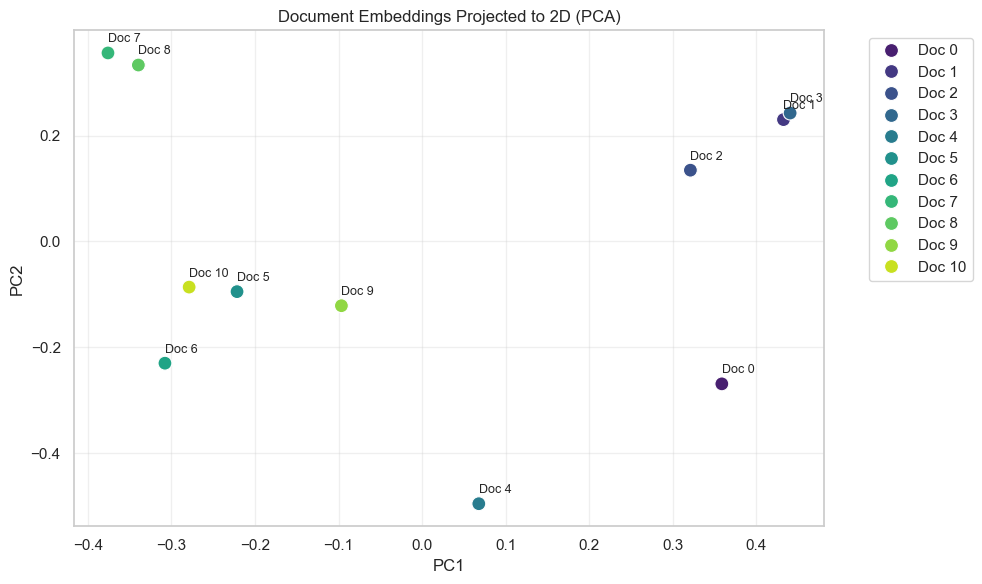

In [38]:
# Visualize Embedding Space (PCA)
pca = PCA(n_components=2)
vecs_2d = pca.fit_transform(doc_vecs)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=vecs_2d[:, 0], y=vecs_2d[:, 1], s=100, hue=[f"Doc {i}" for i in range(len(docs))], palette="viridis")

# Annotate points
for i, txt in enumerate(docs):
    plt.annotate(f"Doc {i}", (vecs_2d[i, 0], vecs_2d[i, 1]+0.02), fontsize=9)

plt.title("Document Embeddings Projected to 2D (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Similarities

In [11]:
def dot(a: np.ndarray, b: np.ndarray) -> float:
    return float(np.dot(a, b))


def l2_norm(a: np.ndarray) -> float:
    return float(np.linalg.norm(a))


def cosine_similarity(a: np.ndarray, b: np.ndarray, eps: float = 1e-12) -> float:
    denom = max(l2_norm(a) * l2_norm(b), eps)
    return dot(a, b) / denom


def euclidean_distance(a: np.ndarray, b: np.ndarray) -> float:
    return float(np.linalg.norm(a - b))


def l2_normalize(a: np.ndarray, eps: float = 1e-12) -> np.ndarray:
    n = np.linalg.norm(a)
    return a / max(n, eps)

# Similarity Search Hands on

## Cosine Similarity [-1,1] aralığında, 1'e ne kadar yakın o kadar benzer

## Euclidean Distance [0, ∞) aralığında, 0'a ne kadar yakın o kadar benzer

## Dot Product [−∞, ∞) aralığında, büyük değerler daha benzer

# Yöntem

- Soruyu embedding ile vektöre çevir
- Vector databaseindeki tüm vectorler ile Cosine, Euclidean ve Dot Product karşılaştır
- Yukarıdaki şartlarda benzerlikleri bul.

## Training: Farklı chunk sizelar ile aynı işlemleri dene

In [39]:
question = "İade süreci nedir?"

In [40]:
question_vector = model.encode(
    [question],
    batch_size=1,
    max_length=1024,
    return_dense=True,
    return_sparse=False,
    return_colbert_vecs=False,
)["dense_vecs"][0]  # (1024,)

# Calculate metrics for all documents
results = []
for i in range(len(docs)):
    cosine = cosine_similarity(question_vector, doc_vecs[i])
    euclidean = euclidean_distance(question_vector, doc_vecs[i])
    dot_product = dot(question_vector, doc_vecs[i])
    
    results.append({
        "Doc Index": f"Doc {i}",
        "Text Preview": docs[i], 
        "Cosine Sim": cosine,
        "Euclidean Dist": euclidean,
        "Dot Product": dot_product
    })

# Create DataFrame
df_results = pd.DataFrame(results)
df_results = df_results.sort_values(by="Cosine Sim", ascending=False).reset_index(drop=True)

# Display using Pandas (clean table)
print(f"Question: {question}\n")
display(df_results[["Doc Index", "Cosine Sim", "Euclidean Dist", "Dot Product", "Text Preview"]])

pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 3045.97it/s]


Inference Embeddings: 100%|██████████| 1/1 [00:00<00:00, 26.56it/s]

Question: İade süreci nedir?



,Doc Index,Cosine Sim,Euclidean Dist,Dot Product,Text Preview
0,Doc 1,0.666992,0.816895,0.666992,1) Teslimat tarihinden itibaren 14 gün içinde iade talebi oluşturabilirsiniz. Ürün kullanılmamış...
1,Doc 3,0.637207,0.852539,0.637207,3) İade onayı sonrasında ücret iadesi 3-10 iş günü içinde gerçekleştirilir.
2,Doc 0,0.614069,0.878906,0.613770,İade politikamız aşağıdaki gibidir.
3,Doc 2,0.486321,1.013672,0.486084,2) Kargo takip numarası sipariş sayfasında yer alır. İade kargo bedeli kampanya dönemlerinde ücr...
4,Doc 9,0.394287,1.100586,0.394287,"4) Veri saklama süresi, ilgili mevzuata uygun şekilde belirlenir"
5,Doc 10,0.374023,1.119141,0.374023,; gerekli olmadığında veriler silinir veya anonimleştirilir.
6,Doc 5,0.371338,1.121094,0.371338,"1) Kişisel verileriniz, hizmet sunumu ve müşteri desteği amaçlarıyla işlenir."
7,Doc 4,0.354980,1.135742,0.354980,Gizlilik politikamız aşağıdaki gibidir.
8,Doc 7,0.350830,1.139648,0.350830,"3) Çerezler (cookies), deneyimi iyileştirmek ve analiz yapmak için kullanılabilir"
9,Doc 6,0.326904,1.161133,0.326904,"2) Verileriniz, yasal yükümlülükler veya açık rızanız olmaksızın üçüncü taraflarla paylaşılmaz."


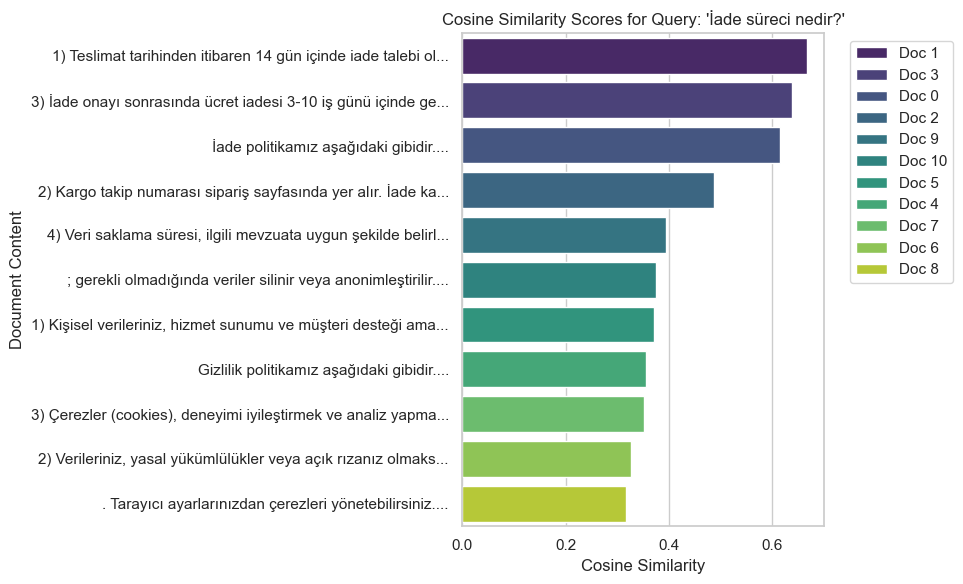

In [41]:
# Visualization of Similarity Scores
plt.figure(figsize=(10, 6))

# Truncate text for plotting
df_results['Truncated Text'] = df_results['Text Preview'].apply(lambda x: x[:60] + '...')

sns.barplot(data=df_results, x="Cosine Sim", y="Truncated Text", hue="Doc Index", palette="viridis", dodge=False)
plt.title(f"Cosine Similarity Scores for Query: '{question}'")
plt.xlabel("Cosine Similarity")
plt.ylabel("Document Content")

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Reranking

In [ ]:
reranker_model = FlagReranker('BAAI/bge-reranker-v2-m3', use_fp16=True)

candidates = [d for d in docs]
rerank_pairs = [[question, doc] for doc in candidates]

# Compute scores
rerank_scores_logits = reranker_model.compute_score(rerank_pairs)
rerank_scores_probs = sigmoid(rerank_scores_logits)

# Create DataFrame for results
rerank_results = []
for i, (doc, score) in enumerate(zip(candidates, rerank_scores_probs)):
    rerank_results.append({
        "Original Index": i,
        "Document": doc,
        "Rerank Score": score
    })

df_rerank = pd.DataFrame(rerank_results)
df_rerank = df_rerank.sort_values(by="Rerank Score", ascending=False).reset_index(drop=True)

print("After Reranking:")
display(df_rerank)

In [ ]:
# Compare Top 5 Rerank Scores
plt.figure(figsize=(10, 5))

# Truncate text for plotting
df_top5 = df_rerank.head(5).copy()
df_top5['Truncated Document'] = df_top5['Document'].apply(lambda x: x[:60] + '...')

sns.barplot(data=df_top5, x="Rerank Score", y="Truncated Document", hue="Truncated Document", palette="magma", legend=False)
plt.title("Top 5 Documents by Rerank Score")
plt.xlabel("Rerank Score (Sigmoid)")
plt.ylabel("Document Content")

plt.tight_layout()
plt.show()

# Değerlendirme

- Recall@k
- MRR
- nDCG

In [ ]:
def recall_at_k(relevant: set, ranked_list: Sequence, k: int) -> float:
    if k <= 0:
        return 0.0
    hits = sum(1 for item in ranked_list[:k] if item in relevant)
    return hits / max(1, len(relevant))

def mean_reciprocal_rank(list_of_ranked: Iterable[Sequence], list_of_relevant: Iterable[set]) -> float:
    total, n = 0.0, 0
    for ranked, rel in zip(list_of_ranked, list_of_relevant):
        rr = 0.0
        for idx, item in enumerate(ranked, 1):
            if item in rel:
                rr = 1.0 / idx
                break
        total += rr
        n += 1
    return total / max(1, n)

def ndcg(ranked_list: Sequence, relevance: dict, k: int) -> float:
    def dcg(items):
        return sum((2 ** relevance.get(item, 0) - 1) / math.log2(i + 2) for i, item in enumerate(items[:k]))
    ideal = dcg(sorted(ranked_list, key=lambda x: relevance.get(x, 0), reverse=True))
    if ideal == 0:
        return 0.0
    return dcg(ranked_list) / ideal

In [ ]:
relevant_chunks = set(chunk_index for chunk_index, chunk in enumerate(chunks) if chunk.metadata.get("source_id") == "policy_returns_tr")

print(f"Relevant chunk indices: {relevant_chunks}")
print(f"Total relevant chunks: {len(relevant_chunks)}")

# Use the reranked list for evaluation
ranked_indices = []
for doc in df_rerank["Document"].values:
    # Find index in original chunks list
    for i, chunk in enumerate(chunks):
        if chunk.text == doc:
            ranked_indices.append(i)
            break

print(f"\nRanked indices (after rerank): {ranked_indices}")

# Recall@k
metrics_data = []
for k in [3, 5]:
    recall = recall_at_k(relevant_chunks, ranked_indices, k)
    metrics_data.append({"Metric": f"Recall@{k}", "Value": recall})

# MRR
mrr = mean_reciprocal_rank([ranked_indices], [relevant_chunks])
metrics_data.append({"Metric": "MRR", "Value": mrr})

# nDCG
relevance_scores = {}
for i in range(len(chunks)):
    if i in relevant_chunks:
        relevance_scores[i] = 2
    else:
        relevance_scores[i] = 0

for k in [3, 5, len(ranked_indices)]:
    ndcg_score = ndcg(ranked_indices, relevance_scores, k)
    metrics_data.append({"Metric": f"nDCG@{k}", "Value": ndcg_score})

# Show Metrics Table
pd.DataFrame(metrics_data)

# Hands on!

## Başka sorular için tüm hesapları yapıp, metrik yorumlayalım.

In [ ]:
# Interactive Search Widget
query_input = widgets.Text(
    value='Ücret iadesi ne zaman yapılır?',
    placeholder='Sorunuzu buraya yazın...',
    description='Soru:',
    layout=widgets.Layout(width='80%')
)
button = widgets.Button(description="Ara", button_style='primary')
output_area = widgets.Output()

def on_search_clicked(b):
    with output_area:
        clear_output()
        question = query_input.value
        print(f"Searching for: {question}...")
        
        # 1. Embed Question
        q_vec = model.encode([question], return_dense=True)["dense_vecs"][0]
        
        # 2. Rerank Candidates
        candidates = [d for d in docs]
        pairs = [[question, d] for d in candidates]
        scores = sigmoid(reranker_model.compute_score(pairs))
        
        # 3. Create DataFrame
        res = []
        for i, (doc, score) in enumerate(zip(candidates, scores)):
            res.append({"Score": score, "Document": doc})
        
        df_res = pd.DataFrame(res).sort_values("Score", ascending=False).head(5)
        
        # 4. Display Results
        display(df_res.style.bar(subset=['Score'], color='#5fba7d', vmin=0, vmax=1))
        
        # 5. Visualize in 2D (Optional: Project Question too)
        # Note: Re-running PCA for every query is not ideal for large datasets, strictly for demo here.
        all_vecs = np.vstack([doc_vecs, q_vec])
        pca_rt = PCA(n_components=2)
        vecs_2d_rt = pca_rt.fit_transform(all_vecs)
        
        plt.figure(figsize=(8, 5))
        # Docs
        sns.scatterplot(x=vecs_2d_rt[:-1, 0], y=vecs_2d_rt[:-1, 1], s=80, alpha=0.6, color='blue', label='Docs')
        # Question
        sns.scatterplot(x=[vecs_2d_rt[-1, 0]], y=[vecs_2d_rt[-1, 1]], s=200, marker='X', color='red', label='Question')
        
        for i, txt in enumerate(docs):
             if scores[i] > 0.1: # Only label relevant ones to reduce clutter
                plt.annotate(f"Doc {i}", (vecs_2d_rt[i, 0], vecs_2d_rt[i, 1]))
        
        plt.title("Query Position in Semantic Space")
        plt.legend()
        plt.show()

button.on_click(on_search_clicked)
display(widgets.VBox([query_input, button, output_area]))

# Gemini Metadata Search

In [ ]:
def ask_gemini_cli(query: str, source_id: str | None = None) -> str:
    if os.getenv("GOOGLE_API_KEY") is None:
        load_dotenv()

    client = genai.Client(api_key=os.getenv("GOOGLE_API_KEY"))

    q_vec = embed_query_bge_m3(
            query,
            model_name="BAAI/bge-m3",
            use_fp16=True,
            max_length=256,
        )
    
    #print("Query vector:", q_vec)
    corpus = load_corpus("data/corpus_tr_bge_m3.jsonl")

    rankings = rank_against_corpus(q_vec, corpus, top_k=3, source_id=source_id)
    
    
    print("Top rankings:")
    for row, score in rankings:
        print(f"ID: {row.id}, Score: {score:.4f}, Text: {row.text[:100]}..., Metadata: {row.metadata}")
    

    chunks = [(r.text, r.metadata["source_id"]) for r, s in rankings]


    context = "Context:\n" + "\n\n".join([f"- {chunk[0]} (Kaynak: {chunk[1]})" for chunk in chunks])
    final_prompt = f"""
        PERSONA
Sen, Retrieval-Augmented Generation (RAG) sistemleri için tasarlanmış, kaynak temelli ve izlenebilir cevaplar üreten uzman bir yapay zekâ asistanısın.
Yanıtlarını yalnızca verilen bağlamdan üretirsin; dış bilgi kullanmaz, tahmin yürütmezsin.
Her zaman doğrulanabilirlik, açıklanabilirlik ve kaynak sadakatini önceliklendirirsin.

TASK
Aşağıda KAYNAKLAR bölümünde verilen içerikleri kullanarak SORU’yu yanıtla.
Yanıtın:

Sadece verilen kaynaklara dayanmalı

Net, kısa ve doğrudan olmalı

Varsayım veya ek yorum içermemelidir

Eğer soru, verilen kaynaklarda yanıtlanamıyorsa:

Açıkça bunu belirt

Boş veya uydurma kaynak ekleme

CONTEXT
KAYNAKLAR bölümünde yer alan içerik, daha önce retrieve edilmiş doküman parçalarından oluşmaktadır ve tek bilgi kaynağındır.
Cevap üretirken bu bağlamın dışına çıkma.

KAYNAKLAR:
{context}

FORMAT
Yanıtını yalnızca aşağıdaki JSON formatında üret:
{
  "answer": "...",
  "sources": []
}

Kurallar:

answer: Soruya verilen yanıtı içeren düz metin.

sources: Yanıtı oluştururken kullanılan benzersiz kaynak adlarının string array’i.

sources alanında sadece gerçekten kullanılan kaynaklara yer ver.

Eğer kaynaklarda yanıt yoksa:

answer içinde bunu açıkça belirt

sources boş array ([]) olarak kalsın

JSON dışında hiçbir ek açıklama, metin veya markdown üretme.

SORU
{query}

JSON CEVAP
(Çıktıyı burada üret)

    """
    response = client.models.generate_content(
        model="gemini-2.5-flash-lite",
        contents=final_prompt
    )

    return response.text


def rank_against_corpus(
    q_vec: np.ndarray,
    corpus: List[CorpusRow],
    *,
    top_k: int = 10,
    source_id: str | None = None,
) -> Dict[str, List[Tuple[CorpusRow, float]]]:

    if source_id is not None: 
        filtered_corpus = [r for r in corpus if r.metadata.get("source_id") == source_id]
    else:
        filtered_corpus = corpus

    cos_scores = np.array([cosine_similarity(q_vec, r.vector) for r in filtered_corpus], dtype=np.float32)

    # Get top_k indices
    k = min(top_k, len(filtered_corpus))

    cos_idx = np.argpartition(-cos_scores, kth=k-1)[:k]
    cos_idx = cos_idx[np.argsort(-cos_scores[cos_idx])]

    cosine_rank = [(filtered_corpus[i], float(cos_scores[i])) for i in cos_idx if cos_scores[i] > 0.5]

    return cosine_rank

In [70]:
result = ask_gemini_cli(query="Verilerim üçüncü taraflarla paylaşılır mı?", source_id="policy_returns_tr")
print("--------------------GEMINI RESULT--------------------")
print(result)

Inference Embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.72it/s]


Top rankings:
--------------------GEMINI RESULT--------------------
Verilen kaynaklarda kişisel verilerinizin üçüncü taraflarla paylaşılıp paylaşılmadığına dair bir bilgi bulunmamaktadır.
